In [1]:
# !pip install torch
# !pip install torchvision

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)

        self.fc_mu = nn.Linear(hidden_dim * 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4, latent_dim)

        # Latent to hidden
        self.z_fc = nn.Linear(latent_dim, hidden_dim * 4)
        
        # Decoder
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        return self.fc_mu(h3), self.fc_logvar(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.z_fc(z))
        h = torch.relu(self.fc4(h))
        h = torch.relu(self.fc5(h))
        x_recon = torch.sigmoid(self.fc6(h))
        return x_recon.view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
# Conv VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(256)

        self.conv_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.conv_logvar = nn.Linear(256 * 2 * 2, latent_dim)
        self.z = nn.Linear(latent_dim, 256 * 2 * 2)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.debatch_norm1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.debatch_norm2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.debatch_norm3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.leaky_relu(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.z(z)
        x = x.view(-1, 256, 2, 2)
        x = self.leaky_relu(self.debatch_norm1(self.deconv1(x)))
        x = self.leaky_relu(self.debatch_norm2(self.deconv2(x)))
        x = self.leaky_relu(self.debatch_norm3(self.deconv3(x)))
        x = self.tanh(self.deconv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:
# Loss function
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

def loss_function_fcvae(recon_x, x, mu, logvar, beta=1):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3072), x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

In [6]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'cvae':
                loss_function = loss_function_cvae
            elif model_name == 'fcvae':
                loss_function = loss_function_fcvae
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

In [7]:
num_epochs = 10
lr = 1e-3

In [8]:
# Train the CVAE
transform_cvae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CIFAR10('./data/cvae', train=True, download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=64, shuffle=True)

cvae = ConvVAE(latent_dim=128).to(device)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [00:59<00:00, 13.20batch/s, kld_loss=41.2, recon_loss=281, train_loss=322]  


Epoch 1/10 train loss: 322.30387815429685 mse loss: 281.0745565136719 kld loss: 41.229321469726564


Epoch 2: 100%|██████████| 782/782 [00:57<00:00, 13.59batch/s, kld_loss=45.8, recon_loss=189, train_loss=234]   


Epoch 2/10 train loss: 234.396561640625 mse loss: 188.58637056640626 kld loss: 45.81019092285156


Epoch 3: 100%|██████████| 782/782 [00:57<00:00, 13.67batch/s, kld_loss=48.4, recon_loss=174, train_loss=222]   


Epoch 3/10 train loss: 221.98672369628906 mse loss: 173.6139872167969 kld loss: 48.3727365625


Epoch 4: 100%|██████████| 782/782 [00:57<00:00, 13.69batch/s, kld_loss=50.4, recon_loss=164, train_loss=214]   


Epoch 4/10 train loss: 214.21758737304688 mse loss: 163.82258590820314 kld loss: 50.395001300048825


Epoch 5: 100%|██████████| 782/782 [00:57<00:00, 13.59batch/s, kld_loss=51.8, recon_loss=159, train_loss=211]   


Epoch 5/10 train loss: 211.08136983886718 mse loss: 159.29503120117187 kld loss: 51.78633851074219


Epoch 6: 100%|██████████| 782/782 [00:57<00:00, 13.67batch/s, kld_loss=52.9, recon_loss=154, train_loss=207]   


Epoch 6/10 train loss: 206.96760919433595 mse loss: 154.10521158691407 kld loss: 52.8623976965332


Epoch 7: 100%|██████████| 782/782 [00:58<00:00, 13.41batch/s, kld_loss=53.9, recon_loss=151, train_loss=205]    


Epoch 7/10 train loss: 204.54108255859376 mse loss: 150.6748409375 kld loss: 53.86624170166016


Epoch 8: 100%|██████████| 782/782 [00:59<00:00, 13.17batch/s, kld_loss=54.5, recon_loss=148, train_loss=203]   


Epoch 8/10 train loss: 202.80057935546876 mse loss: 148.27279075195312 kld loss: 54.52778874267578


Epoch 9: 100%|██████████| 782/782 [00:59<00:00, 13.11batch/s, kld_loss=55, recon_loss=146, train_loss=201]     


Epoch 9/10 train loss: 200.89404060546875 mse loss: 145.88421229003907 kld loss: 55.00982845947266


Epoch 10: 100%|██████████| 782/782 [00:58<00:00, 13.26batch/s, kld_loss=55.4, recon_loss=144, train_loss=200]   

Epoch 10/10 train loss: 199.80783620117188 mse loss: 144.41168448242186 kld loss: 55.39615165649414


In [13]:
# Train the FCVAE
transform_fcvae = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fcvae = datasets.CIFAR10('./data/fcvae', train=True, download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=64, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=1000, latent_dim=128)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [02:22<00:00,  5.49batch/s, kld_loss=9.42, recon_loss=1.98e+3, train_loss=1.99e+3]


Epoch 1/10 train loss: 1990.1540435546874 mse loss: 1980.7314066796876 kld loss: 9.422636966466904


Epoch 2: 100%|██████████| 782/782 [03:39<00:00,  3.56batch/s, kld_loss=9.6, recon_loss=1.93e+3, train_loss=1.94e+3] 


Epoch 2/10 train loss: 1935.517459453125 mse loss: 1925.91654765625 kld loss: 9.600911233520508


Epoch 3: 100%|██████████| 782/782 [03:33<00:00,  3.67batch/s, kld_loss=9.63, recon_loss=1.91e+3, train_loss=1.92e+3]


Epoch 3/10 train loss: 1921.0502537109376 mse loss: 1911.4193765625 kld loss: 9.630874804992676


Epoch 4: 100%|██████████| 782/782 [03:34<00:00,  3.64batch/s, kld_loss=9.76, recon_loss=1.91e+3, train_loss=1.92e+3]


Epoch 4/10 train loss: 1915.8673262890625 mse loss: 1906.107766484375 kld loss: 9.759562708435059


Epoch 5: 100%|██████████| 782/782 [03:31<00:00,  3.70batch/s, kld_loss=12.4, recon_loss=1.89e+3, train_loss=1.9e+3] 


Epoch 5/10 train loss: 1902.476807265625 mse loss: 1890.0698708203124 kld loss: 12.40693894165039


Epoch 6: 100%|██████████| 782/782 [03:30<00:00,  3.71batch/s, kld_loss=13.4, recon_loss=1.88e+3, train_loss=1.89e+3]


Epoch 6/10 train loss: 1893.3847823828125 mse loss: 1880.0251065234374 kld loss: 13.359676856079101


Epoch 7: 100%|██████████| 782/782 [03:29<00:00,  3.73batch/s, kld_loss=14.4, recon_loss=1.87e+3, train_loss=1.89e+3]


Epoch 7/10 train loss: 1887.0972333984375 mse loss: 1872.734196875 kld loss: 14.363037100219726


Epoch 8: 100%|██████████| 782/782 [58:15<00:00,  4.47s/batch, kld_loss=14.5, recon_loss=1.87e+3, train_loss=1.88e+3]


Epoch 8/10 train loss: 1884.480997578125 mse loss: 1869.95183046875 kld loss: 14.529165731506348


Epoch 9: 100%|██████████| 782/782 [03:18<00:00,  3.94batch/s, kld_loss=15.5, recon_loss=1.86e+3, train_loss=1.88e+3]


Epoch 9/10 train loss: 1880.1849038671876 mse loss: 1864.678712421875 kld loss: 15.506191895446777


Epoch 10: 100%|██████████| 782/782 [06:44<00:00,  1.94batch/s, kld_loss=15.9, recon_loss=1.86e+3, train_loss=1.88e+3]

Epoch 10/10 train loss: 1877.053266171875 mse loss: 1861.164114453125 kld loss: 15.889152008361817


In [20]:
# Function to generate and display new images
def generate_images(model, model_name, num_images, latent_dim):
    if np.sqrt(num_images) % 1 != 0:
        raise ValueError('num_images must be a perfect square')
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(next(model.parameters()).device)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image', colour='blue'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    if model_name == 'cvae':
        # Rescale the images to the range [-1, 1]
        generated_images = (generated_images + 1) / 2

    # Rescale the images to the range [0, 1]
    generated_images = torch.clamp(generated_images, 0, 1)

    grid_size = int(np.sqrt(num_images))

    # Plot the generated images
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size + 1, grid_size + 1))
    axs = axs.flatten() if len(axs.shape) == 2 else axs
    for i in range(num_images):
        axs[i].imshow(generated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Images from FC VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 257.95image/s]


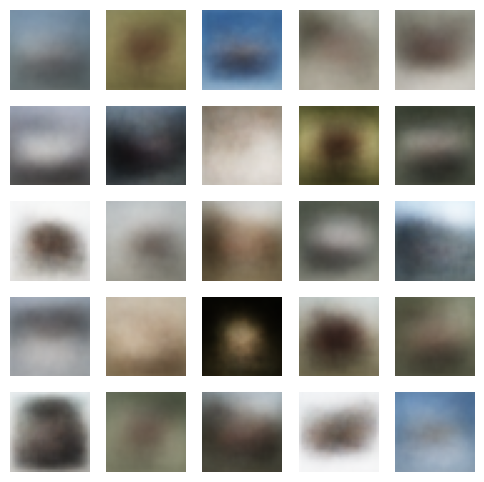

Images from Conv VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 151.16image/s]


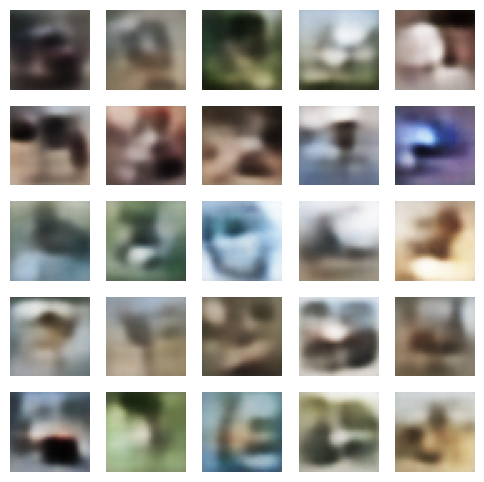

In [21]:
# Generate images
print('Images from FC VAE')
generate_images(fcvae, 'fcvae', num_images=25, latent_dim=128)

print('Images from Conv VAE')
generate_images(cvae, 'cvae', num_images=25, latent_dim=128)

In [113]:
def interpolate_images(model, model_name, image1, image2, device, num_steps=10):
    model.eval()
    with torch.no_grad():
        if model_name == 'cvae':
            if image1.shape[1] == 1:
                image1 = image1.repeat(1, 3, 1, 1)
            if image2.shape[1] == 1:
                image2 = image2.repeat(1, 3, 1, 1)
        image1 = image1.to(device)
        image2 = image2.to(device)
        mu1, logvar1 = model.encode(image1)
        mu2, logvar2 = model.encode(image2)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            interpolated_z = alpha * z2 + (1 - alpha) * z1
            reconstructed_image = model.decode(interpolated_z).cpu()
            if model_name == 'cvae':
                reconstructed_image = (reconstructed_image + 1) / 2
            interpolated_images.append(reconstructed_image)
        interpolated_images = torch.cat(interpolated_images, dim=0)
        return torch.clamp(interpolated_images, 0, 1)

In [114]:
def visualize_interpolation(model, model_name, dataset, num_steps=10):
    data_iter = iter(dataset)
    image1, _ = next(data_iter)
    image2, _ = next(data_iter)
    image1 = image1.unsqueeze(0).to(device)  # No need to flatten the image
    image2 = image2.unsqueeze(0).to(device)  # No need to flatten the image
    # Ensure 3 channels before passing to the model
    if image1.shape[1] == 1:
        image1 = image1.repeat(1, 3, 1, 1)  # Convert grayscale to RGB if necessary
    if image2.shape[1] == 1:
        image2 = image2.repeat(1, 3, 1, 1)  # Convert grayscale to RGB if necessary
    interpolated_images = interpolate_images(model, model_name, image1, image2, device, num_steps=num_steps)
    fig, axs = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        axs[i].imshow(interpolated_images[i].permute(1, 2, 0).cpu().numpy())
        axs[i].axis('off')
    plt.show()

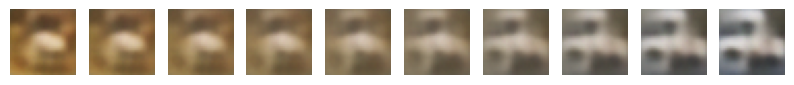

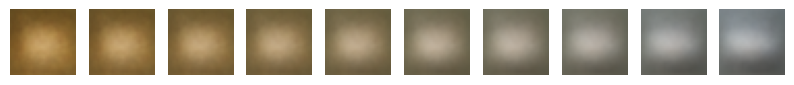

In [119]:
# Interpolate between two images from the dataset for Conv VAE
visualize_interpolation(cvae, 'cvae', train_dataset_cvae, num_steps=10)

# Interpolate between two images from the dataset for FC VAE
visualize_interpolation(fcvae, 'fcvae', train_dataset_fcvae, num_steps=10)